In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r"C:\Users\ADMIN\Downloads\loan_data_2007_2014_preprocessed.csv")
data.head(5)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4632\499374408.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\ADMIN\Downloads\loan_data_2007_2014_preprocessed.csv")


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [3]:
LEAKAGE_COLS = [
    "out_prncp", "out_prncp_inv",
    "total_pymnt", "total_pymnt_inv",
    "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "next_pymnt_d", "last_credit_pull_d"
]


In [4]:
leakage_status_cols = [c for c in data.columns if c.startswith("loan_status")]
data = data.drop(columns=LEAKAGE_COLS + leakage_status_cols, errors="ignore")

In [5]:
data.shape

(466285, 186)

In [6]:
data['installment_to_inc_ratio'] = data['installment'] / (data['annual_inc'] / 12 + 1)
data['inq_per_year_history'] = data['inq_last_6mths'] / ((data['mths_since_earliest_cr_line'] / 12) + 1)
data['dti_per_open_acc'] = data['dti'] / (data['open_acc'] + 1)

In [7]:
data['issue_d_date'] = pd.to_datetime(data['issue_d_date'])

data = data.sort_values('issue_d_date')

train = data[data['issue_d_date'] < '2014-01-01'].copy()
test = data[data['issue_d_date'] >= '2014-01-01'].copy()

print(f"Train Date Range: {train['issue_d_date'].min()} to {train['issue_d_date'].max()}")
print(f"Test Date Range: {test['issue_d_date'].min()} to {test['issue_d_date'].max()}")
print(f'Train data: {len(train)}')
print(f'Test Data: {len(test)}')

Train Date Range: 2007-06-01 00:00:00 to 2013-12-01 00:00:00
Test Date Range: 2014-01-01 00:00:00 to 2014-12-01 00:00:00
Train data: 230657
Test Data: 235628


In [8]:
train = train.drop(columns='int_rate')
train.shape

(230657, 188)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pure_features = [
    'loan_amnt', 'annual_inc', 'dti', 'inq_last_6mths', 
    'revol_util', 'emp_length_int', 'mths_since_earliest_cr_line',
    'open_acc', 'pub_rec', 'total_acc',
    'installment_to_inc_ratio', 'inq_per_year_history', 'dti_per_open_acc'
]

x_train, y_train = train[pure_features], train['good_bad']
x_test, y_test = test[pure_features], test['good_bad']

pure_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

pure_pipe.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score

probs = pure_pipe.predict_proba(x_test)[:, 1]

print(f"Baseline ROC-AUC: {roc_auc_score(y_test, probs):.3f}")
print(f"Baseline PR-AUC (Average Precision): {average_precision_score(y_test, probs):.3f}")

Baseline ROC-AUC: 0.620
Baseline PR-AUC (Average Precision): 0.944


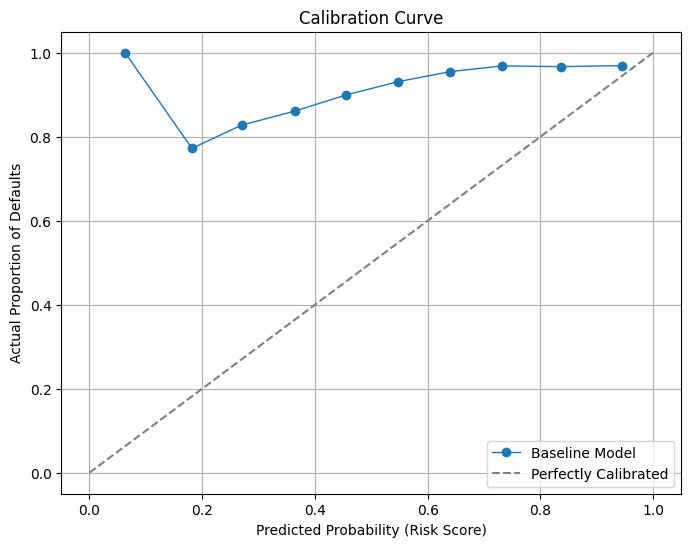

In [11]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Baseline Model')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Predicted Probability (Risk Score)')
plt.ylabel('Actual Proportion of Defaults')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, probs)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.2392


In [13]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

x_train_sub, x_calib, y_train_sub, y_calib = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

pure_pipe.fit(x_train_sub, y_train_sub)

calibrator = CalibratedClassifierCV(pure_pipe, method='isotonic', cv=5)
calibrator.fit(x_calib, y_calib)

calibrated_probs = calibrator.predict_proba(x_test)[:, 1]

new_brier = brier_score_loss(y_test, calibrated_probs)
print(f"New Calibrated Brier Score: {new_brier:.4f}")

New Calibrated Brier Score: 0.0778


In [14]:
test['issue_quarter'] = test['issue_d_date'].dt.to_period('Q')

def evaluate_quarter(group):
    probs = calibrator.predict_proba(group[pure_features])[:, 1]
    actuals = group['good_bad']
    return pd.Series({
        'auc_roc': roc_auc_score(actuals, probs),
        'brier_score': brier_score_loss(actuals, probs),
        'sample_size': len(group)
    })

quarterly_analysis = test.groupby('issue_quarter').apply(evaluate_quarter, include_groups=False).reset_index()
quarterly_analysis['issue_quarter'] = quarterly_analysis['issue_quarter'].astype(str)
print(quarterly_analysis)

  issue_quarter   auc_roc  brier_score  sample_size
0        2014Q1  0.613443     0.090974      47410.0
1        2014Q2  0.611021     0.085703      55349.0
2        2014Q3  0.619991     0.077025      58726.0
3        2014Q4  0.624913     0.064003      74143.0


In [15]:
full_auc = quarterly_analysis['auc_roc'].mean()
full_brier = quarterly_analysis['brier_score'].mean()

print(f"Full Model Reference - AUC: {full_auc:.4f}, Brier: {full_brier:.4f}\n")

Full Model Reference - AUC: 0.6173, Brier: 0.0794



In [16]:
baseline_global_auc = roc_auc_score(y_test, calibrated_probs)
baseline_global_brier = brier_score_loss(y_test, calibrated_probs)

print(f"--- Global Baseline (Logistic Regression) ---")
print(f"Direct AUC: {baseline_global_auc:.4f}")
print(f"Direct Brier: {baseline_global_brier:.4f}")

--- Global Baseline (Logistic Regression) ---
Direct AUC: 0.6185
Direct Brier: 0.0778


In [17]:
results = []
for feature_to_drop in pure_features:
    reduced_features = [f for f in pure_features if f != feature_to_drop]
    x_train_reduced = x_train_sub[reduced_features]
    x_calib_reduced = x_calib[reduced_features]
    x_test_reduced = x_test[reduced_features]
    
    reduced_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', random_state=42))
    ])
    reduced_pipe.fit(x_train_reduced, y_train_sub)

    calibrator_reduced = CalibratedClassifierCV(reduced_pipe, method='isotonic', cv=5)
    calibrator_reduced.fit(x_calib_reduced, y_calib)
    calibrator_probs_reduced = calibrator_reduced.predict_proba(x_test_reduced)[:, 1]

    auc_drop = full_auc - roc_auc_score(y_test, calibrator_probs_reduced)
    brier_change = brier_score_loss(y_test, calibrator_probs_reduced) - full_brier

    results.append({
        'Dropped Feature': feature_to_drop,
        'AUC Drop': auc_drop,
        'Brier Increase': brier_change
    })

ablation_df = pd.DataFrame(results).sort_values(by='AUC Drop', ascending=False)
print(ablation_df)

                Dropped Feature  AUC Drop  Brier Increase
10     installment_to_inc_ratio  0.003069       -0.001425
4                    revol_util  0.001876       -0.001412
2                           dti  0.000601       -0.001696
6   mths_since_earliest_cr_line  0.000453       -0.001651
3                inq_last_6mths  0.000212       -0.001439
5                emp_length_int -0.000686       -0.001655
12             dti_per_open_acc -0.001026       -0.001654
7                      open_acc -0.001144       -0.001663
11         inq_per_year_history -0.001169       -0.001651
8                       pub_rec -0.001283       -0.001649
1                    annual_inc -0.002141       -0.001774
9                     total_acc -0.002149       -0.001696
0                     loan_amnt -0.002251       -0.001797


In [18]:
data['util_velocity'] = data['revol_util'] / (data['total_acc'] + 1)

data['income_stability'] = data['annual_inc'] * (data['emp_length_int'] + 1)

data['inquiry_burn'] = data['inq_last_6mths'] / (data['open_acc'] + 1)

advanced_features = pure_features + ['util_velocity', 'income_stability', 'inquiry_burn']

In [19]:
from xgboost import XGBClassifier

train_adv = data[data['issue_d_date'] < '2014-01-01'].copy()
test_adv = data[data['issue_d_date'] >= '2014-01-01'].copy()

x_train_adv = train_adv[advanced_features]
y_train_adv = train_adv['good_bad']
x_test_adv = test_adv[advanced_features]
y_test_adv = test_adv['good_bad']

x_train_sub, x_calib, y_train_sub, y_calib = train_test_split(
    x_train_adv, y_train_adv, test_size=0.2, random_state=42, stratify=y_train_adv
)

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.01,
    scale_pos_weight=10, 
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(x_train_sub, y_train_sub)

calibrator_xgb = CalibratedClassifierCV(xgb_model, method='isotonic', cv=3)
calibrator_xgb.fit(x_calib, y_calib)

xgb_probs = calibrator_xgb.predict_proba(x_test_adv)[:, 1]

print(f"XGBoost Pure Risk AUC: {roc_auc_score(y_test_adv, xgb_probs):.4f}")
print(f"XGBoost Brier Score: {brier_score_loss(y_test_adv, xgb_probs):.4f}")

XGBoost Pure Risk AUC: 0.6190
XGBoost Brier Score: 0.0779


In [20]:
error_df = x_test_adv.copy()
error_df['actual'] = y_test_adv
error_df['prob_good'] = xgb_probs

confident_defaults = error_df[(error_df['actual'] == 0) & (error_df['prob_good'] > 0.80)].copy()

print(f"Total Test Set size: {len(error_df)}")
print(f"Number of 'Confident Failures': {len(confident_defaults)}")

Total Test Set size: 235628
Number of 'Confident Failures': 15800


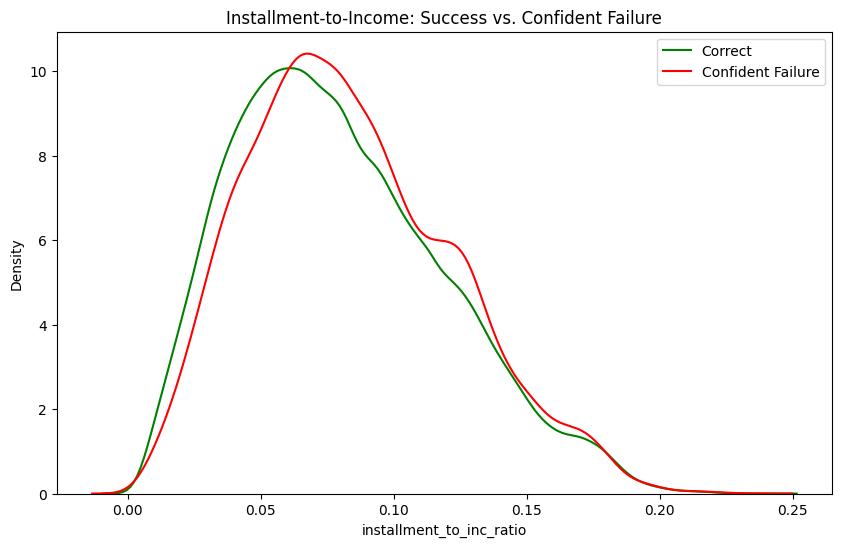

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(error_df[error_df['actual'] == 1]['installment_to_inc_ratio'], label='Correct', color='green')
sns.kdeplot(confident_defaults['installment_to_inc_ratio'], label='Confident Failure', color='red')
plt.title('Installment-to-Income: Success vs. Confident Failure')
plt.legend()
plt.show()

In [23]:
conf_fail_indices = confident_defaults.index

purpose_in_failures = test_adv.loc[conf_fail_indices, 'purpose'].value_counts(normalize=True)
purpose_overall = test_adv['purpose'].value_counts(normalize=True)

purpose_gap = (purpose_in_failures - purpose_overall).sort_values(ascending=False)

print("--- Loan Purposes where the Model is Systematically Blind ---")
print(purpose_gap.head(5))

--- Loan Purposes where the Model is Systematically Blind ---
purpose
debt_consolidation    0.029039
other                 0.008517
small_business        0.007172
moving                0.004111
medical               0.004095
Name: proportion, dtype: float64


In [31]:
test_adv['policy_prob'] = xgb_probs

blind_spots = ['debt_consolidation', 'small_business', 'other']
test_adv.loc[test_adv['purpose'].isin(blind_spots), 'policy_prob'] -= 0.05

threshold = 0.80

standard_rejections = (xgb_probs < threshold).sum()
policy_rejections = (test_adv['policy_prob'] < threshold).sum()

standard_defaults_caught = test_adv[(xgb_probs < threshold) & (test_adv['good_bad'] == 0)].shape[0]
policy_defaults_caught = test_adv[(test_adv['policy_prob'] < threshold) & (test_adv['good_bad'] == 0)].shape[0]

print(f"Standard Policy caught {standard_defaults_caught} defaults.")
print(f"New Policy caught {policy_defaults_caught} defaults.")
print(f"Extra Defaults Avoided: {policy_defaults_caught - standard_defaults_caught}")

Standard Policy caught 3641 defaults.
New Policy caught 8796 defaults.
Extra Defaults Avoided: 5155


In [32]:
standard_good_rejected = test_adv[(xgb_probs < threshold) & (test_adv['good_bad'] == 1)].shape[0]
policy_good_rejected = test_adv[(test_adv['policy_prob'] < threshold) & (test_adv['good_bad'] == 1)].shape[0]

lost_customers = policy_good_rejected - standard_good_rejected

print(f"Extra 'Good' loans rejected: {lost_customers}")
print(f"Efficiency Ratio: {lost_customers / (policy_defaults_caught - standard_defaults_caught):.2f}")

Extra 'Good' loans rejected: 41896
Efficiency Ratio: 8.13
